# Génération d'idées de recettes selon ce que l'on a chez soi

### Projet Python - 2A ENSAE

Projet réalisé par BRESSON Claire, CASSANT Emile, MEKKI Lila

## Introduction 

Notre objectif était de faciliter la tâche à ceux qui ne savent pas quoi manger alors que leur frigo n'est pas vide, et qui cherchent des idées de recettes à réaliser à la maison. 

## I. Récupération des données ingrédients 

Pour récupérer la liste des ingrédients disponibles dans la grande distribution, nous avons trouvé deux bases de données principales : l'OpenFoodFacts et Ciqual. La base de données d'OpenFoodFacts était cependant trop conséquente, donc nous avons choisi de nous concentrer sur la base Ciqual, plus petite. 

In [2]:
!pip install xlrd
!pip install unidecode
!pip install rapidfuzz
!pip install wordcloud
!pip install nltk

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import rapidfuzz
import time
from wordcloud import WordCloud
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re # for regular expressions 
from re import sub

In [4]:
# Lien du fichier et affichage 

data_ciqual = pd.read_excel("https://ciqual.anses.fr/cms/sites/default/files/inline-files/Table%20Ciqual%202020_FR_2020%2007%2007.xls") 
data_ciqual.head()

,alim_grp_code,alim_ssgrp_code,alim_ssssgrp_code,alim_grp_nom_fr,alim_ssgrp_nom_fr,alim_ssssgrp_nom_fr,alim_code,alim_nom_fr,alim_nom_sci,"Energie, Règlement UE N° 1169/2011 (kJ/100 g)",...,Vitamine K1 (µg/100 g),Vitamine K2 (µg/100 g),Vitamine C (mg/100 g),Vitamine B1 ou Thiamine (mg/100 g),Vitamine B2 ou Riboflavine (mg/100 g),Vitamine B3 ou PP ou Niacine (mg/100 g),Vitamine B5 ou Acide pantothénique (mg/100 g),Vitamine B6 (mg/100 g),Vitamine B9 ou Folates totaux (µg/100 g),Vitamine B12 (µg/100 g)
0,0,0,0,NaN,NaN,NaN,24999,Dessert (aliment moyen),NaN,NaN,...,NaN,NaN,"1,37","0,084","0,15","0,61","0,4","0,056","30,8","0,21"
1,1,101,0,entrées et plats composés,salades composées et crudités,-,25601,"Salade de thon et légumes, appertisée",NaN,-,...,-,-,"2,75","< 0,04","0,053","4,45","< 0,16","0,29",31,"1,45"
2,1,101,0,entrées et plats composés,salades composées et crudités,-,25602,"Salade composée avec viande ou poisson, appert...",NaN,-,...,"9,75",-,-,"0,032","0,022","4,13","0,2","0,12","11,1","1,23"
3,1,101,0,entrées et plats composés,salades composées et crudités,-,25605,"Champignons à la grecque, appertisés",NaN,-,...,-,-,"6,67","0,056","0,21","1,84","0,88","0,088","19,6","0,018"
4,1,101,0,entrées et plats composés,salades composées et crudités,-,25606,"Salade de pommes de terre, fait maison",NaN,-,...,-,-,10,"0,077","0,06","0,89","0,53","0,14",7,0


On décide de ne garder que les colonnes contenant le nom de l'aliment, son apport énérgétique, ainsi que certains substrats énergétiques courants (Glucides, Protéines,...). 

In [5]:
data_ciqual = data_ciqual[['alim_grp_nom_fr','alim_nom_fr','Energie, Règlement UE N° 1169/2011 (kJ/100 g)',
       'Energie, Règlement UE N° 1169/2011 (kcal/100 g)',
       'Protéines, N x 6.25 (g/100 g)', 'Glucides (g/100 g)',
       'Lipides (g/100 g)', 'Sucres (g/100 g)', 'Fructose (g/100 g)',
       'Glucose (g/100 g)', 'Lactose (g/100 g)','Saccharose (g/100 g)', 'Amidon (g/100 g)']]
#data_ciqual.head()

On renomme les colonnes pour plus de lisibilité.

In [6]:
new_names = {
    'alim_grp_nom_fr': 'Groupe',
    'alim_nom_fr': 'Nom aliment',
    'Energie, Règlement UE N° 1169/2011 (kJ/100 g)':'Energie kJ',
    'Energie, Règlement UE N° 1169/2011 (kcal/100 g)': 'Energie kcal',
    'Protéines, N x 6.25 (g/100 g)': 'Protéines',
    'Glucides (g/100 g)': 'Glucides',
    'Lipides (g/100 g)' : 'Lipides',
    'Sucres (g/100 g)'  : 'Sucres',
    'Fructose (g/100 g)': 'Fructose',
    'Glucose (g/100 g)' : 'Glucose',
    'Lactose (g/100 g)' : 'Lactose',
    'Saccharose (g/100 g)': 'Saccharose',
    'Amidon (g/100 g)'  : 'Amidon'
}

data_ciqual.rename(columns=new_names, inplace=True)

In [7]:
data_ciqual["Groupe"].unique()

array([nan, 'entrées et plats composés',
       'fruits, légumes, légumineuses et oléagineux',
       'produits céréaliers', 'viandes, œufs, poissons et assimilés',
       'produits laitiers et assimilés', 'eaux et autres boissons',
       'produits sucrés', 'glaces et sorbets', 'matières grasses',
       'aides culinaires et ingrédients divers', 'aliments infantiles'],
      dtype=object)

Nous voulons nous concentrer sur les aliments non transformés étant donné que l'on veut élaborer une recette nous-mêmes. Nous éliminons également les boissons et aliments infantiles. Nous garons les 'produits sucrés', bien qu'ils contiennent de nombreux produits transformés, car ils contiennent également des produits tels que 'spéculoos', qui peuvent être utiles dans les recettes. 

In [8]:
#Suppression de certains groupes alimentaires 

mask = data_ciqual['Groupe'].isin(['entrées et plats composés', 'eaux et autres boissons', 'aliments infantiles'])
data_ciqual = data_ciqual.drop(data_ciqual[mask].index)
data_ciqual.head()

,Groupe,Nom aliment,Energie kJ,Energie kcal,Protéines,Glucides,Lipides,Sucres,Fructose,Glucose,Lactose,Saccharose,Amidon
0,NaN,Dessert (aliment moyen),NaN,NaN,"4,61","36,6","12,9","23,7","1,81","2,18","1,89","15,7","9,53"
338,"fruits, légumes, légumineuses et oléagineux","Avocat, pulpe, cru",843,205,"1,56","0,83","20,6","0,4","0,16","0,16","< 0,2","< 0,2","< 0,35"
339,"fruits, légumes, légumineuses et oléagineux","Bette ou blette, crue","68,3","16,4",1,"1,63","< 0,5","1,2","0,5","0,7","< 0,2","< 0,2","< 0,35"
340,"fruits, légumes, légumineuses et oléagineux","Carotte, crue",169,"40,2","0,63","7,59","< 0,5",6,"0,9","1,1","< 0,2",4,"0,4"
341,"fruits, légumes, légumineuses et oléagineux","Champignon, tout type, cru","91,2","21,7","2,37","1,88","0,23","1,43","0,17","0,82",0,"< 0,1",0


Afin de pouvoir exploiter les données sur les apports énergétiques, nous regardons les proportions de NaN dans les différentes colonnes relatives aux apports. 

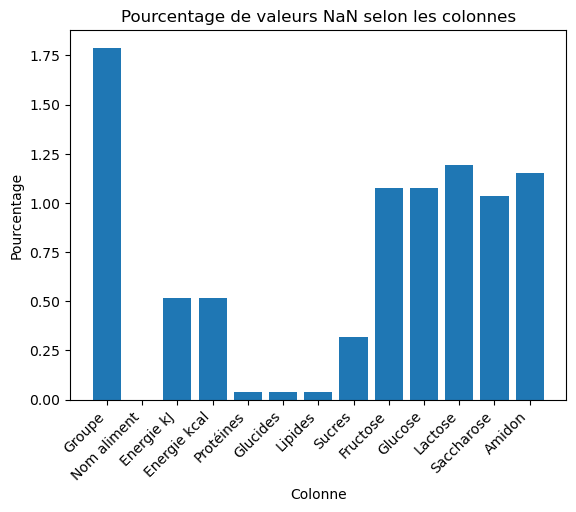

In [9]:
# Calcul des données manquantes selon les différentes colonnes

n = len(data_ciqual)
percentages = []
for col in (list(data_ciqual.columns)):
    percentages.append(((data_ciqual[col].isna()).sum()/n)*100)
plt.bar(data_ciqual.columns, percentages)
plt.xlabel('Colonne')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45, ha='right')
plt.title('Pourcentage de valeurs NaN selon les colonnes')
plt.show()

Les valeurs principales qui nous intéressent sont dans un premier temps le nom des aliments étant donné que l'on veut un matching avec les noms d'aliments présents dans les recettes sur Marmiton. Dans un second temps, si nous voulons traiter l'apport énergétique nous nous intéresserons également à ces données. 
Les résultats sont donc très satisfaisants car il n'y a aucun nom d'aliment manquant et les apports sont manquants à hauteur de seulement 1%.

## II. Simplification des ingrédients et normalisation (NLP)

Afin de relier les ingrédients des recettes aux ingrédients de la base, nous devons nous assurer que les noms des ingrédients sont clairs et similaires à ceux des recettes. Nous vérifions donc qu'il n'existe pas de doublons ou d'ingrédients trop similaires dans la base Ciqual. Nous mettons ensuite en place des méthodes de distance pour comparer les ingrédients. 

La librairie **unidecode** sur Python permet de produire une représentation ASCII (American Standard Code for Information Interchange) d'un texte donné. Dans notre cas, elle va permettre de supprimer les accents sur les noms des aliments.

Afin d'identifier les mots superflus dans les noms d'aliments, on affiche un nuage de mots. 

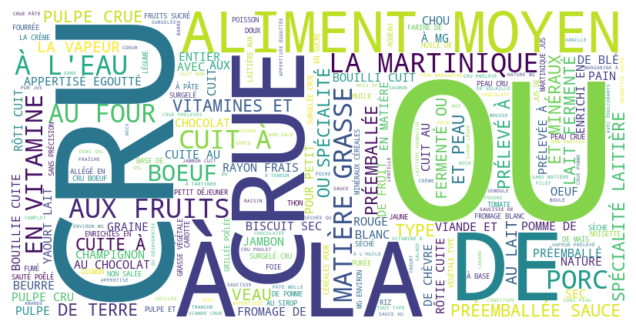

In [10]:
concat_aliments = ' '.join(data_ciqual["Nom aliment"].apply(lambda row : row.upper()))
cloud = WordCloud(width=800, height=400, background_color='white').generate(concat_aliments)
plt.figure(figsize=(8, 4))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

On réalise qu'il y a pour le moment beaucoup de bruit dans les noms d'aliments, tel que **cru** ou **aliment**. On définit donc une liste de stopwords (qui ne doit pas être trop grande néanmoins car on veut pouvoir apparier les aliments avec ceux des recettes).

In [14]:
nltk.download('stopwords')
nltk.download('punkt')

def cleaning(s):
    stop_words_spe = ['CRU','CRUE','ALIMENT','TOUT','TYPE','PREEMBALLE','PREEMBALLEE','PREEMBALLEES','MOYEN','CUIT',
                      'CUITE','PETIT DEJEUNER','ROTI','ROTIE','FOUR','AU FOUR','KG','CL','G','L','MG','MARTINIQUE',
                      'VITAMINES','MINERAUX'
                     ]
    stop_words_default = [s.upper() for s in stopwords.words('french')]
    stop_words = set(stop_words_default + stop_words_spe)
    s = unidecode(s)
    s = s.upper()
    s = sub("[^A-Z ]", " ", s)
    mots = word_tokenize(s)
    mots_filtres = [mot for mot in mots if mot not in stop_words]
    #from nltk.stem.snowball import FrenchStemmer
    #s = " ".join(FrenchStemmer().stem(s) for s in s.split())
    return ' '.join(mots_filtres)
    

# Apply the function to the column of ingredients' names 
data_ciqual["Nom clean"] = data_ciqual["Nom aliment"].apply(cleaning)
#data_ciqual

[nltk_data] Downloading package stopwords to /Users/lila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


On affiche le nouveau nuage de mots, plus clair cette fois ! 

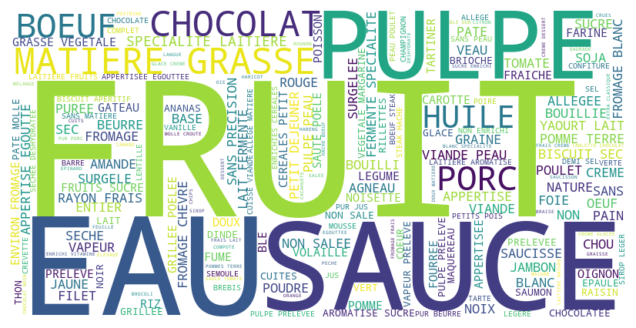

In [15]:
concat_aliments = ' '.join(data_ciqual["Nom clean"])
cloud = WordCloud(width=800, height=400, background_color='white').generate(concat_aliments)
plt.figure(figsize=(8, 4))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Distance entre les aliments de Ciqual et la recette

En première approche, nous décidons d'utiliser la **distance de Levenshtein** à l'aide du package rapidfuzz de python. 

In [224]:
rapidfuzz.distance.Levenshtein.distance('sucre blanc','sucre roux', weights =(1,1,1))

5

## Matching avec les ingrédients de la recette 

On crée ensuite une fonction qui associe à chaque ingrédient de la recette, les ingrédients présents dans la base de données et leur apport calorique.

In [63]:
from itertools import product
from difflib import SequenceMatcher
from jellyfish import jaro_winkler_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

distances ={}

# Levenshtein distance 

distances["lev"] = lambda s1,s2 : rapidfuzz.distance.Levenshtein.normalized_distance(s1, s2,weights =(1,1,1))

# Similarity ratio  
distances["sqcmatcher"] = lambda s1, s2: 1 - SequenceMatcher(None, s1, s2).ratio()

# Jaro-Winkler similarity

distances["jaro_winkler"] = lambda s1, s2 : jaro_winkler_similarity(s1,s2)

# Cosine similarity 
distances["cosine"] = lambda s1,s2 : cosine_similarity([CountVectorizer().fit_transform[s1,s2].toarray()[0]],
                                                      [CountVectorizer().fit_transform[s1,s2].toarray()[1]])[0][0]

# Jaccard similarity 

#distances["jaccard"] = lambda s1,s2 : len(set(s1).intersection(set(s2)))/len(set(s1).union(set(s2)))






In [88]:
def calcul_match(ingr_recette,ingr_ciqual,metrique):

    """ 
    returns the ingrédients in the Ciqual database that best match the ingredients 
    of the recipe we try to reproduce 
    
    """
    # On nettoie les ingrédients de la recette passés en entrée 

    #ingr_clean = pd.DataFrame([cleaning(ingr) for ingr in ingr_recette])
    ingr_clean = cleaning(ingr_recette)
    # Produit cartésien entre la recette et les produits Ciqual et obtention des distances 
 
    #ingr_ciqual["dist"] = ingr_ciqual["Nom clean"].apply(lambda prod : rapidfuzz.distance.Levenshtein.normalized_distance(prod,ingr_clean,weights =(1,1,1)))

    ingr_ciqual["dist"] = ingr_ciqual["Nom clean"].apply(lambda prod : metrique(prod,ingr_clean))
    #produits_combines = list(product(ingr_recette, produits_ciqual))

    
    return ingr_ciqual.sort_values("dist").head(5)


test = ["sel123","poivre","carotte jaune haché","purée de tomate (passata)"]

calcul_match("carotte",data_ciqual,dist)

,Groupe,Nom aliment,Energie kJ,Energie kcal,Protéines,Glucides,Lipides,Sucres,Fructose,Glucose,Lactose,Saccharose,Amidon,Nom clean,dist
468,"fruits, légumes, légumineuses et oléagineux","Carotte, cuite","78,8","18,9","0,55","2,6","0,1","1,3","< 0,5","< 0,5","< 0,5","1,3","< 0,5",CAROTTE,0.000000
340,"fruits, légumes, légumineuses et oléagineux","Carotte, crue",169,"40,2","0,63","7,59","< 0,5",6,"0,9","1,1","< 0,2",4,"0,4",CAROTTE,0.000000
542,"fruits, légumes, légumineuses et oléagineux","Carotte, purée",132,"31,5","0,88","5,06","< 0,3","4,8","0,51","0,26","< 0,1","4,03","< 0,35",CAROTTE PUREE,0.092308
564,"fruits, légumes, légumineuses et oléagineux","Carotte, cuite à la vapeur",175,"41,6","0,63","7,33","0,3","6,9","0,8","0,9","< 0,2","5,2","< 0,35",CAROTTE A VAPEUR,0.112500
528,"fruits, légumes, légumineuses et oléagineux","Carotte, surgelée, cuite",137,"32,9","0,58","4,52","0,68","4,08","0,28","0,36",0,"3,44","0,31",CAROTTE SURGELEE,0.112500


In [87]:
def compare(mots,prods,distances):
    mots_clean = [cleaning(m) for m in mots]
    data_comp = pd.DataFrame({"Nom alim":mots_clean})
    for m in mots_clean:
        for nom_dist,f_dist in distances.items():
            print(f'{nom_dist}:{f_dist}')
            prods["dist"] = prods["Nom clean"].apply(lambda p : f_dist(p,m))
            data_comp[nom_dist] = float(prods.sort_values("dist").head(1)["dist"])
            data_comp["Match"] = str(prods.sort_values("dist").head(1)["Nom clean"])
            print(data_comp)
    return mesures 

compare(["sel123","poivre","carotte jaune haché","purée de tomate (passata)"],data_ciqual,distances)

lev:<function <lambda> at 0x153db1260>
               Nom alim  lev                                         Match
0                   SEL  0.5  2528    MIEL\nName: Nom clean, dtype: object
1                POIVRE  0.5  2528    MIEL\nName: Nom clean, dtype: object
2   CAROTTE JAUNE HACHE  0.5  2528    MIEL\nName: Nom clean, dtype: object
3  PUREE TOMATE PASSATA  0.5  2528    MIEL\nName: Nom clean, dtype: object
sqcmatcher:<function <lambda> at 0x153db0220>
               Nom alim  lev                                           Match  \
0                   SEL  0.5  389    OSEILLE\nName: Nom clean, dtype: object   
1                POIVRE  0.5  389    OSEILLE\nName: Nom clean, dtype: object   
2   CAROTTE JAUNE HACHE  0.5  389    OSEILLE\nName: Nom clean, dtype: object   
3  PUREE TOMATE PASSATA  0.5  389    OSEILLE\nName: Nom clean, dtype: object   

   sqcmatcher  
0         0.4  
1         0.4  
2         0.4  
3         0.4  
jaro_winkler:<function <lambda> at 0x153db1120>
           

/var/folders/p2/mz39_3ld1931_8d18wv6l6jh0000gn/T/ipykernel_5641/3600825537.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data_comp[nom_dist] = float(prods.sort_values("dist").head(1)["dist"])
/var/folders/p2/mz39_3ld1931_8d18wv6l6jh0000gn/T/ipykernel_5641/3600825537.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data_comp[nom_dist] = float(prods.sort_values("dist").head(1)["dist"])
/var/folders/p2/mz39_3ld1931_8d18wv6l6jh0000gn/T/ipykernel_5641/3600825537.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data_comp[nom_dist] = float(prods.sort_values("dist").head(1)["dist"])


TypeError: 'method' object is not subscriptable